# Analysing nutritional information of menu items at different Fast-Food Companies


In [406]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

df = pd.read_csv("FastFoodNutritionMenuV2.csv")
df.head()

,Company,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g),Weight WatchersPnts
0,McDonald’s,Hamburger,250,80,9,3.5,0.5,25,520,31,2,6,12,247.5
1,McDonald’s,Cheeseburger,300,110,12,6,0.5,40,750,33,2,6,15,297
2,McDonald’s,Double Cheeseburger,440,210,23,11,1.5,80,1150,34,2,7,25,433
3,McDonald’s,McDouble,390,170,19,8,1,65,920,33,2,7,22,383
4,McDonald’s,Quarter Pounder® with Cheese,510,230,26,12,1.5,90,1190,40,3,9,29,502


In [407]:
df.shape

(1148, 14)

In [408]:
# Just getting an idea of what companies are involved 
# and what proprtion of the data belongs to each company
(df.groupby("Company")["Item"].count()*100)/df.shape[0]

Company
Burger King    16.550523
KFC            18.989547
McDonald’s     28.658537
Pizza Hut       6.445993
Taco Bell      15.940767
Wendy’s        13.414634
Name: Item, dtype: float64

## Cleaning and Wrangling the data

In [409]:
# remove whitespaces
df.columns  = df.columns.str.strip()

# convert some columns columns to numeric
for column in df.columns:
    if column != "Company" and column != "Item":
        df[column] = pd.to_numeric(df[column], errors="coerce")

In [410]:
# find out the proportion of null values for each column
def show_null_proportion():
    row = []
    for column in df.columns:
        # find proportions for each column
        row.append(df[df.isnull().any(axis=1)][column].isnull().sum()/df.shape[0])

    null_prop_df = pd.DataFrame(columns=df.columns)
    null_prop_df.loc[0] = row
    return null_prop_df

In [411]:
show_null_proportion()

,Company,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g),Weight WatchersPnts
0,0.0,0.0,0.013066,0.45122,0.060105,0.060976,0.060105,0.025261,0.013937,0.060976,0.073171,0.026132,0.060105,0.236934


The Calories from Fat and Weight WatchersPnts columns seem to have a lot of missing values.
After calculating some Weight Watcher values using online calculators, the values in the table do not seem to be consistent. Therefore it's best to not consider finding Weight WatchersPnts for all entries

We will drop the Weight WatchersPnts column

In [412]:
df.drop(columns=["Weight WatchersPnts"], inplace=True)

In [413]:
df.head()

,Company,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g)
0,McDonald’s,Hamburger,250.0,80.0,9.0,3.5,0.5,25.0,520.0,31.0,2.0,6.0,12.0
1,McDonald’s,Cheeseburger,300.0,110.0,12.0,6.0,0.5,40.0,750.0,33.0,2.0,6.0,15.0
2,McDonald’s,Double Cheeseburger,440.0,210.0,23.0,11.0,1.5,80.0,1150.0,34.0,2.0,7.0,25.0
3,McDonald’s,McDouble,390.0,170.0,19.0,8.0,1.0,65.0,920.0,33.0,2.0,7.0,22.0
4,McDonald’s,Quarter Pounder® with Cheese,510.0,230.0,26.0,12.0,1.5,90.0,1190.0,40.0,3.0,9.0,29.0


Calories from Fat can be calculated by:
Calories from Fat = 9(c/g) * Total Fat(g)

We can confirm that the data, where Total Fat and Calories from Fat do exist, roughly matches this formula

In [414]:
# we should expect when we divide Total Fat * 9 by Calories from Fat we get 1
test_df = df.dropna()
(test_df["Total Fat(g)"]*9 / test_df["Calories from Fat"]).describe()

count    437.000000
mean       1.003696
std        0.069578
min        0.900000
25%        0.981818
50%        1.001408
75%        1.020000
max        1.800000
dtype: float64

### Dealing with missing values
We will fill in the rest of the data in the Calories from Fat column using the formula, when the total fat does exist

In [415]:
def fill_cal_from_fat(r):
    # if "Calories from Fat" is empty and total fat exists
    if pd.isna(r["Calories from Fat"]) and not pd.isna(r["Total Fat(g)"]):
        
        return r["Total Fat(g)"] * 9
    # leave as it is
    return r["Calories from Fat"]

df["Calories from Fat"] = df.apply(fill_cal_from_fat, axis=1)

In [416]:
#check the new proportion
print(df[df.isnull().any(axis=1)]["Calories from Fat"].isnull().sum()/df.shape[0])

0.06010452961672474


Now deleting rows where all values are null (Items that have absolutely no information about them other than item name and company)

In [417]:
# filter enrtries that don't have all of these columns null
df = df[df[["Calories", "Calories from Fat", "Total Fat(g)", "Saturated Fat(g)", "Trans Fat(g)", "Cholesterol(mg)", "Sodium (mg)", "Carbs(g)", "Fiber(g)", "Sugars(g)", "Protein(g)" ]].notna().any(axis=1)]

In [418]:
show_null_proportion()

,Company,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g)
0,0.0,0.0,0.0,0.047661,0.047661,0.048544,0.047661,0.012357,0.000883,0.048544,0.0609,0.013239,0.047661


In [419]:
companies = df.groupby("Company")["Item"].count().keys()

## Exploring the Data

### Investigating which Fast-Food companies are the most and least healthy

In [420]:
# function that gets a columns filtered by company
def get_companies_dataseries(column:str):
    info =  []
    for company in companies:
        # some columns are heavily skewed by items with 0 eg. sauce packets, drinks
        # can cause the mean to become 0 
        info.append(df[(df["Company"] == company) & (df[column] != 0)][column].dropna())
    return info

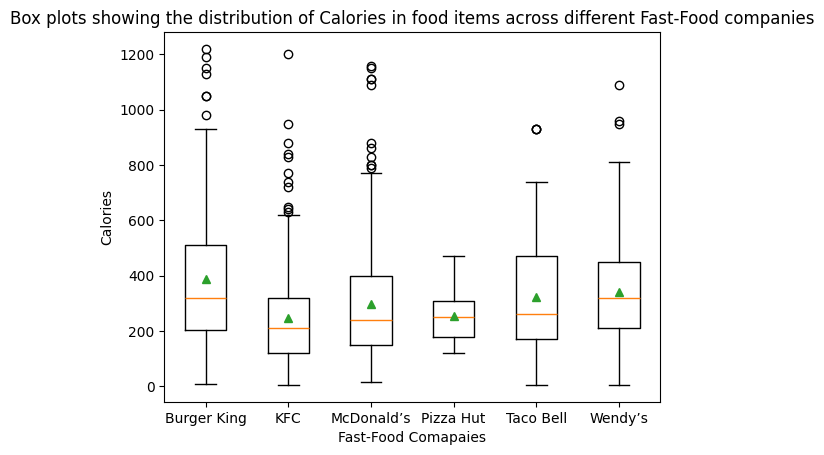

In [421]:
cal_info =  get_companies_dataseries("Calories")

plt.boxplot(cal_info, tick_labels=companies, showmeans=True)
plt.ylabel("Calories")
plt.xlabel("Fast-Food Comapaies")
plt.title("Box plots showing the distribution of Calories in food items across different Fast-Food companies")
plt.show()


In [422]:
for i in range(len(companies)):
    print(str(cal_info[i].median()) +" ", end="")

320.0 210.0 240.0 250.0 260.0 320.0 

It's clear that Burger King and Wendy's have the highest median calories. However, Burger King has a high range and IQR of Calories for their menu items, which suggest they offer a wider veriety of high/low calorie food. Pizza hut has the smallest IQR which suggests it has food that a more calorie consistent. Companies other than Pizza Hut have outliers which implies they have a couple of menu items that are highly calorie dense. McDonald's, Taco Bell and Pizza Hut have very similar median calories in their food 

Burger King has the highest mean calories and more possibility for higher calorie options. KFC has fewer high calorie options with much lower average calories. Similarly with Pizza Hut having medium average calories but having much fewer high calorie options.

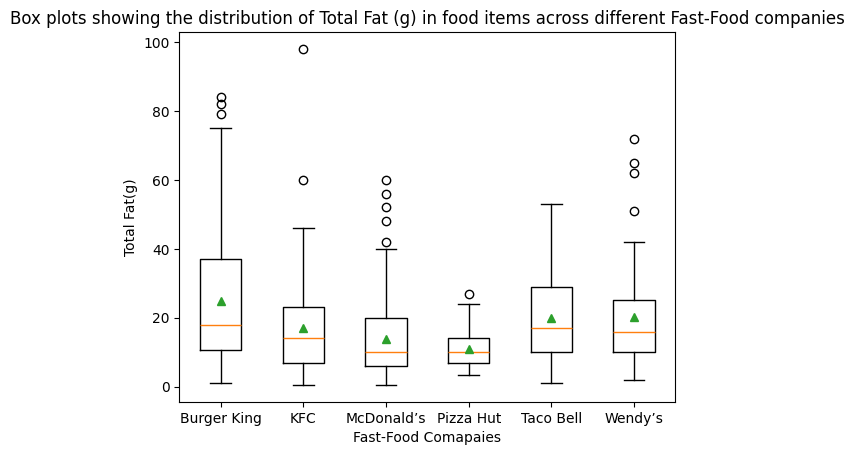

In [423]:
fat_info =  get_companies_dataseries("Total Fat(g)")

plt.boxplot(fat_info, tick_labels=companies, showmeans=True)
plt.ylabel("Total Fat(g)")
plt.xlabel("Fast-Food Comapaies")
plt.title("Box plots showing the distribution of Total Fat (g) in food items across different Fast-Food companies")
plt.show()


In [424]:
for i in range(len(companies)):
    print(str(fat_info[i].median()) +" ", end="")

18.0 14.0 10.0 10.0 17.0 16.0 

Burger King has the highest median total fat (18g) in their items with Taco Bell and Wendy's trailing very closely. McDonald's and Pizza Hut have the lowest medians total fat (10g). However, McDonald's mean is higher due to having more outliers so Pizza Hut can be taken to have the lowest total fat.
Burger King has the highest highest range of total fat in their food items also indicating a wide variety of menu options. Pizza Hut has again displayed the lowest range of total fat in their menu. 

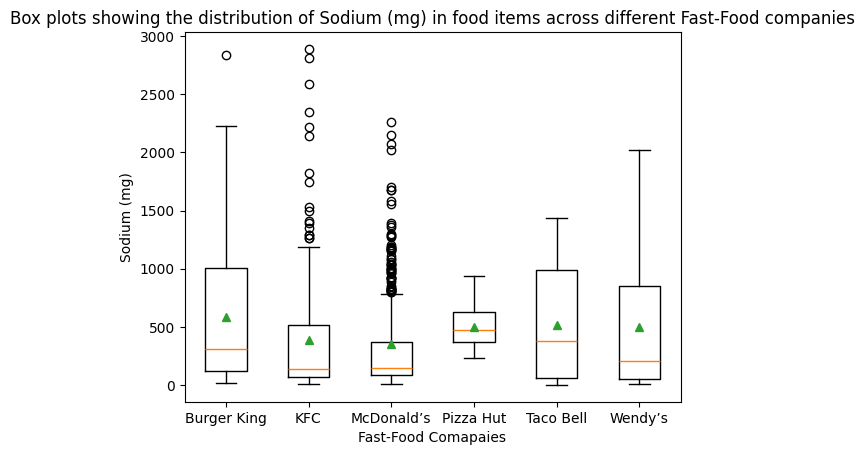

In [425]:
sod_info =  get_companies_dataseries("Sodium (mg)")

plt.boxplot(sod_info, tick_labels=companies, showmeans=True)
plt.ylabel("Sodium (mg)")
plt.xlabel("Fast-Food Comapaies")
plt.title("Box plots showing the distribution of Sodium (mg) in food items across different Fast-Food companies")
plt.show()


In [426]:
for i in range(len(companies)):
    print(str(sod_info[i].median()) +" ", end="")

310.0 140.0 150.0 475.0 380.0 210.0 

This time Pizza Hut has the highest median sodium on their menu (475mg). This is followed by Taco Bell (380mg) and Burger King (310mg) The rest (KFC, McDonald's, Wendy's) have much lower sodium in their menu. 
Burger King and Wendy's have the highest ranges and Pizza Hut and McDonald's have the lowest.
This time most of the data seems to be right-skewed indicated by the mean departing from the median, with McDonald's having significantly more outliers than any other.

<hr>
From this information only, it's clear that Burger is the most unhealthy in calories, total fat and sodium. It comes first twice for calories and total fat in terms of median and consistently has the highest range. Pizza Hut was clearly the most nutrient consistent and KFC was arguably least unhealthy among the six options.

Pizza Hut's overall consistency may be explained due to its high proportion of pizzas, since most of a pizza remain the same with just the toppings varying

In [427]:
print(df[(df["Company"]== "Pizza Hut") & (df["Item"].str.contains("pizza", case=False))]["Item"].count()/df[df["Company"]== "Pizza Hut"]["Item"].count())

0.527027027027027


## Grouping data using Machine Learning

Menu items can include fried food, salad, drinks etc. These menu items are likely to vary in their nutrients but we can expect menu items of the same group to vary little compared to menu items in different groups. We can group menu items using K-means clustering. 

In [428]:
df.dropna(inplace=True)

In [429]:
df.describe()

,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g)
count,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000,1034.000000
mean,296.653772,105.314313,11.701644,4.121373,0.147002,37.620890,446.735977,39.540619,1.434236,23.651838,9.508704
std,226.415889,127.768291,14.188886,5.109594,0.499424,67.329056,506.930104,32.068610,2.404020,32.185701,11.185768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,17.000000,0.000000,2.000000,0.000000
50%,255.000000,70.000000,8.000000,3.000000,0.000000,15.000000,200.000000,34.500000,0.000000,8.000000,7.000000
75%,410.000000,160.000000,18.000000,6.000000,0.000000,45.000000,717.500000,53.000000,2.000000,38.000000,14.000000
max,1220.000000,882.000000,98.000000,33.000000,4.500000,575.000000,2890.000000,270.000000,31.000000,264.000000,71.000000


In [430]:
scaler = StandardScaler()

Transforming the data into a standard form. This is done by subtracting the mean from every point and dividing by the standard deviation. This ensures the data from all columns are treated with equal weight and are in the same range so that they can be compared.

In [431]:
df[["Calories_T","Calories from Fat_T","Total Fat(g)_T","Saturated Fat(g)_T","Trans Fat(g)_T","Cholesterol(mg)_T","Sodium (mg)_T","Carbs(g)_T","Fiber(g)_T","Sugars(g)_T","Protein(g)_T"]] = scaler.fit_transform(df[["Calories","Calories from Fat","Total Fat(g)","Saturated Fat(g)","Trans Fat(g)","Cholesterol(mg)","Sodium (mg)","Carbs(g)","Fiber(g)","Sugars(g)","Protein(g)"]])

In [432]:
df.head()

,Company,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),...,Calories from Fat_T,Total Fat(g)_T,Saturated Fat(g)_T,Trans Fat(g)_T,Cholesterol(mg)_T,Sodium (mg)_T,Carbs(g)_T,Fiber(g)_T,Sugars(g)_T,Protein(g)_T
0,McDonald’s,Hamburger,250.0,80.0,9.0,3.5,0.5,25.0,520.0,31.0,...,-0.198223,-0.190498,-0.121668,0.707152,-0.187542,0.144595,-0.266452,0.235455,-0.548703,0.222828
1,McDonald’s,Cheeseburger,300.0,110.0,12.0,6.0,0.5,40.0,750.0,33.0,...,0.036691,0.021038,0.367844,0.707152,0.035353,0.598526,-0.204056,0.235455,-0.548703,0.491156
2,McDonald’s,Double Cheeseburger,440.0,210.0,23.0,11.0,1.5,80.0,1150.0,34.0,...,0.819737,0.796667,1.346869,2.710426,0.629737,1.387971,-0.172858,0.235455,-0.517618,1.385581
3,McDonald’s,McDouble,390.0,170.0,19.0,8.0,1.0,65.0,920.0,33.0,...,0.506518,0.514620,0.759454,1.708789,0.406843,0.934040,-0.204056,0.235455,-0.517618,1.117254
4,McDonald’s,Quarter Pounder® with Cheese,510.0,230.0,26.0,12.0,1.5,90.0,1190.0,40.0,...,0.976346,1.008203,1.542674,2.710426,0.778333,1.466916,0.014332,0.651626,-0.455448,1.743352


### Identifying optimal number of clusters
**inertia**: The sum of the squared distances to the centre of the cluster.
we will fit a bunch of k-means clustering models with the number of clusters varying. At some point the inertia should start to show "diminishing returns". The value at which this happens will be our K value

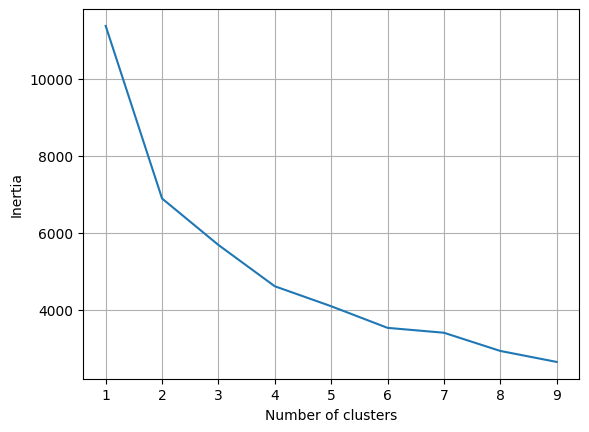

In [433]:
means = []
inertias = []

# try 1 to 10 clusters
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df[["Calories_T","Calories from Fat_T","Total Fat(g)_T","Saturated Fat(g)_T","Trans Fat(g)_T","Cholesterol(mg)_T","Sodium (mg)_T","Carbs(g)_T","Fiber(g)_T","Sugars(g)_T","Protein(g)_T"]])
    means.append(k)
    inertias.append(kmeans.inertia_)

plt.plot(means, inertias)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


### Applying the K-means with K = 4

We will pick our k value to be 4

In [405]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df[["Calories_T","Calories from Fat_T","Total Fat(g)_T","Saturated Fat(g)_T","Trans Fat(g)_T","Cholesterol(mg)_T","Sodium (mg)_T","Carbs(g)_T","Fiber(g)_T","Sugars(g)_T","Protein(g)_T"]])


,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [358]:
# contains the labels for each row in order of the df ranging from 1-4
df["kmeans_3"] = kmeans.labels_

In [359]:
means_of_clusters = df.drop(columns=["Company", "Item"]).groupby("kmeans_3").mean()

In [361]:
means_of_clusters.drop(columns=["Calories_T","Calories from Fat_T","Total Fat(g)_T","Saturated Fat(g)_T","Trans Fat(g)_T","Cholesterol(mg)_T","Sodium (mg)_T","Carbs(g)_T","Fiber(g)_T","Sugars(g)_T","Protein(g)_T"], inplace=True)

In [362]:
means_of_clusters

,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),Fiber(g),Sugars(g),Protein(g)
kmeans_3,,,,,,,,,,,
0,344.486692,149.891635,16.625475,5.193916,0.114068,44.049430,711.140684,34.315589,2.866920,5.437262,14.783270
1,918.421053,515.000000,57.210526,22.684211,2.868421,186.578947,1573.684211,50.368421,2.473684,10.526316,51.736842
2,467.226891,61.731092,6.865546,4.239496,0.310924,22.773109,174.663866,101.210084,0.277311,93.806723,5.294118
3,647.192982,331.780702,36.842105,11.206140,0.267544,145.877193,1406.228070,54.315789,4.324561,8.464912,24.535088
4,133.545279,27.975915,3.127168,1.315029,0.000000,8.535645,123.121387,24.406551,0.300578,20.612717,2.955684


### Visualising the results

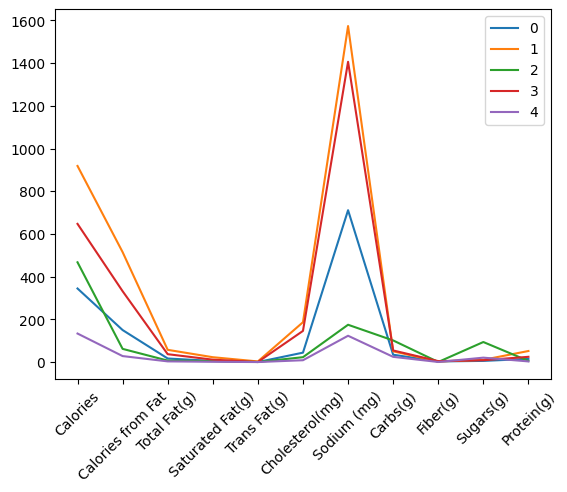

In [376]:
for i in range (0,5):
    plt.plot( means_of_clusters.columns, means_of_clusters.loc[i], label=i)
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [360]:
df.head()

,Company,Item,Calories,Calories from Fat,Total Fat(g),Saturated Fat(g),Trans Fat(g),Cholesterol(mg),Sodium (mg),Carbs(g),...,Total Fat(g)_T,Saturated Fat(g)_T,Trans Fat(g)_T,Cholesterol(mg)_T,Sodium (mg)_T,Carbs(g)_T,Fiber(g)_T,Sugars(g)_T,Protein(g)_T,kmeans_3
0,McDonald’s,Hamburger,250.0,80.0,9.0,3.5,0.5,25.0,520.0,31.0,...,-0.190498,-0.121668,0.707152,-0.187542,0.144595,-0.266452,0.235455,-0.548703,0.222828,0
1,McDonald’s,Cheeseburger,300.0,110.0,12.0,6.0,0.5,40.0,750.0,33.0,...,0.021038,0.367844,0.707152,0.035353,0.598526,-0.204056,0.235455,-0.548703,0.491156,0
2,McDonald’s,Double Cheeseburger,440.0,210.0,23.0,11.0,1.5,80.0,1150.0,34.0,...,0.796667,1.346869,2.710426,0.629737,1.387971,-0.172858,0.235455,-0.517618,1.385581,3
3,McDonald’s,McDouble,390.0,170.0,19.0,8.0,1.0,65.0,920.0,33.0,...,0.514620,0.759454,1.708789,0.406843,0.934040,-0.204056,0.235455,-0.517618,1.117254,0
4,McDonald’s,Quarter Pounder® with Cheese,510.0,230.0,26.0,12.0,1.5,90.0,1190.0,40.0,...,1.008203,1.542674,2.710426,0.778333,1.466916,0.014332,0.651626,-0.455448,1.743352,3
